Iteration 1, Residual Norm: 55.20809140061175
Iteration 2, Residual Norm: 3.4099775419146408
Iteration 3, Residual Norm: 0.21062151444972896
Iteration 4, Residual Norm: 0.013009370350822926
Iteration 5, Residual Norm: 0.0008035484965033083
Iteration 6, Residual Norm: 4.963295683789034e-05
Iteration 7, Residual Norm: 3.0657053281933755e-06
Iteration 8, Residual Norm: 1.8936345702336825e-07
Converged after 8 iterations with residual norm: 1.8936345702336825e-07


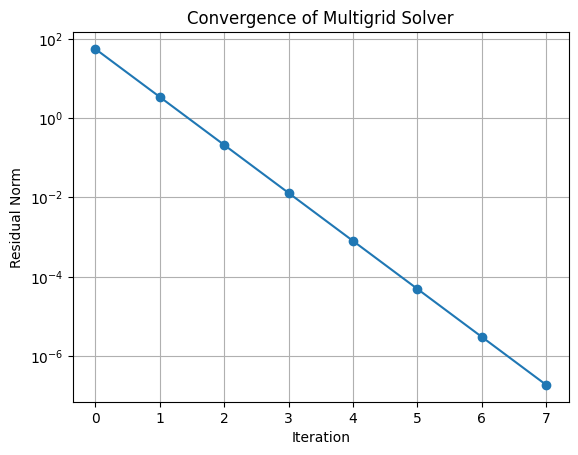

Error Norm: 0.006426291127082197


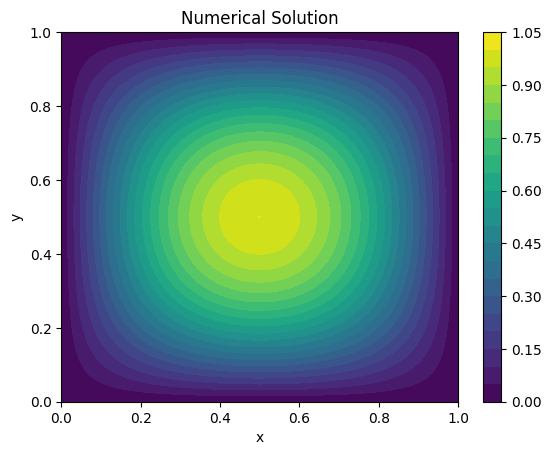

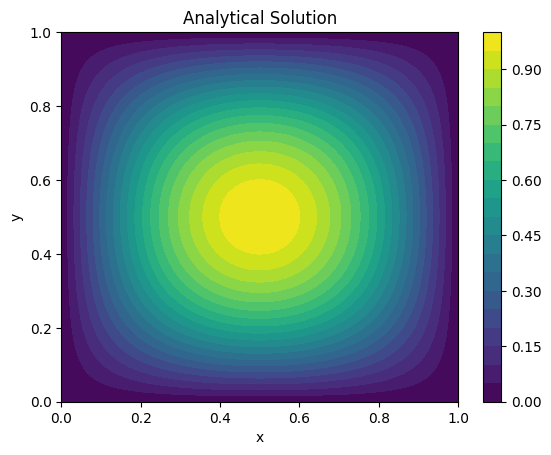

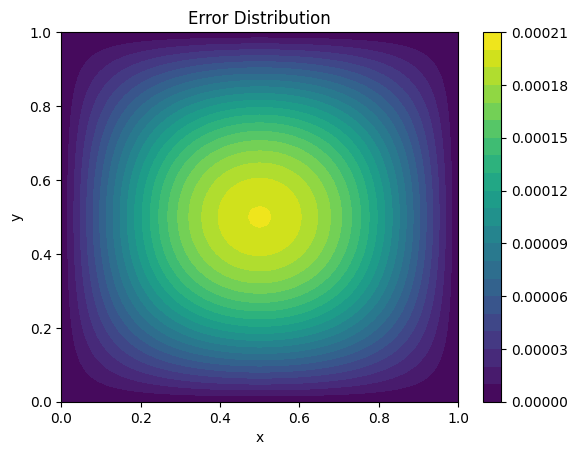

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = M = 65  # Grid size (must be 2^n + 1 for multigrid)
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, M)
X, Y = np.meshgrid(x, y)

max_iterations = 20
tolerance = 1e-6

# Initialize the solution
p = np.zeros((N, M))

# Right-hand side 'b' based on the test problem
b = -2 * np.pi**2 * np.sin(np.pi * X) * np.sin(np.pi * Y)

# Analytical solution
p_exact = np.sin(np.pi * X) * np.sin(np.pi * Y)

# Apply Dirichlet boundary conditions
def apply_boundary_conditions(p):
    p[0, :] = 0
    p[-1, :] = 0
    p[:, 0] = 0
    p[:, -1] = 0
    return p

# Red-Black Gauss-Seidel smoother
def gauss_seidel_rb(p, b, iterations, dx, dy):
    N, M = p.shape
    for _ in range(iterations):
        for i in range(1, N - 1):
            for j in range(1 + (i % 2), M - 1, 2):
                p[i, j] = 0.25 * (
                    p[i-1, j] + p[i+1, j] + p[i, j-1] + p[i, j+1] - b[i, j] * dx**2
                )
        for i in range(1, N - 1):
            for j in range(1 + ((i + 1) % 2), M - 1, 2):
                p[i, j] = 0.25 * (
                    p[i-1, j] + p[i+1, j] + p[i, j-1] + p[i, j+1] - b[i, j] * dx**2
                )
    return p

# Restriction operator (full-weighting)
def restrict(residual):
    N_fine, M_fine = residual.shape
    N_coarse = (N_fine - 1) // 2 + 1
    M_coarse = (M_fine - 1) // 2 + 1
    rc = np.zeros((N_coarse, M_coarse))
    for i in range(1, N_coarse - 1):
        for j in range(1, M_coarse - 1):
            i_fine = 2 * i
            j_fine = 2 * j
            rc[i, j] = (1/16) * (
                residual[i_fine-1, j_fine-1] + 2*residual[i_fine-1, j_fine] + residual[i_fine-1, j_fine+1] +
                2*residual[i_fine, j_fine-1] + 4*residual[i_fine, j_fine] + 2*residual[i_fine, j_fine+1] +
                residual[i_fine+1, j_fine-1] + 2*residual[i_fine+1, j_fine] + residual[i_fine+1, j_fine+1]
            )
    rc[0, :] = residual[0, ::2]
    rc[-1, :] = residual[-1, ::2]
    rc[:, 0] = residual[::2, 0]
    rc[:, -1] = residual[::2, -1]
    return rc

# Prolongation operator (bilinear interpolation)
def prolong(e_coarse):
    N_coarse, M_coarse = e_coarse.shape
    N_fine = 2 * (N_coarse - 1) + 1
    M_fine = 2 * (M_coarse - 1) + 1
    ef = np.zeros((N_fine, M_fine))

    ef[::2, ::2] = e_coarse
    ef[1::2, ::2] = 0.5 * (e_coarse[:-1, :] + e_coarse[1:, :])
    ef[::2, 1::2] = 0.5 * (e_coarse[:, :-1] + e_coarse[:, 1:])
    ef[1::2, 1::2] = 0.25 * (
        e_coarse[:-1, :-1] + e_coarse[1:, :-1] + e_coarse[:-1, 1:] + e_coarse[1:, 1:]
    )
    return ef

# Multigrid V-cycle
def multigrid_V_cycle(p, b, depth, dx, dy):
    N, M = p.shape
    if depth == 0 or min(N, M) <= 3:
        return gauss_seidel_rb(p, b, iterations=10, dx=dx, dy=dy)
    p = gauss_seidel_rb(p, b, iterations=2, dx=dx, dy=dy)
    residual = np.zeros_like(p)
    residual[1:-1, 1:-1] = b[1:-1, 1:-1] - (
        (p[1:-1, 2:] + p[1:-1, :-2] + p[2:, 1:-1] + p[:-2, 1:-1] - 4 * p[1:-1, 1:-1]) / dx**2
    )
    residual_coarse = restrict(residual)
    error_coarse = np.zeros_like(residual_coarse)
    dx_coarse = dx * 2
    dy_coarse = dy * 2
    error_coarse = multigrid_V_cycle(error_coarse, residual_coarse, depth - 1, dx_coarse, dy_coarse)
    error_fine = prolong(error_coarse)
    p += error_fine
    p = gauss_seidel_rb(p, b, iterations=2, dx=dx, dy=dy)
    return p

# Main solver loop
dx = dy = 1.0 / (N - 1)
global_residuals = []

for i in range(max_iterations):
    p = multigrid_V_cycle(p, b, depth=int(np.log2(N - 1)), dx=dx, dy=dy)
    p = apply_boundary_conditions(p)
    residual = np.zeros_like(p)
    residual[1:-1, 1:-1] = b[1:-1, 1:-1] - (
        (p[1:-1, 2:] + p[1:-1, :-2] + p[2:, 1:-1] + p[:-2, 1:-1] - 4 * p[1:-1, 1:-1]) / dx**2
    )
    residual_norm = np.linalg.norm(residual)
    global_residuals.append(residual_norm)
    print(f"Iteration {i+1}, Residual Norm: {residual_norm}")
    if residual_norm < tolerance:
        print(f"Converged after {i+1} iterations with residual norm: {residual_norm}")
        break
else:
    print("Did not converge within the maximum number of iterations.")

# Plot residual norm
plt.figure()
plt.semilogy(global_residuals, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Residual Norm')
plt.title('Convergence of Multigrid Solver')
plt.grid(True)
plt.show()

# Compute and report error
error = np.abs(p - p_exact)
error_norm = np.linalg.norm(error)
print(f"Error Norm: {error_norm}")

# Plot solutions and error
titles = ['Numerical Solution', 'Analytical Solution', 'Error Distribution']
fields = [p, p_exact, error]

for title, field in zip(titles, fields):
    plt.figure()
    plt.contourf(X, Y, field, levels=20, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
